# Pip Installs

In [1]:
!pip install datasets==3.0.0 transformers==4.31.0 matplotlib==3.7.1
!apt-get install git-lfs
!pip install -q -U google-generativeai
!pip install jsonlines
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Succes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# Import Statements

In [2]:
# All import statements

import collections
from collections import Counter

import json
import jsonlines

import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy import sparse
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from itertools import chain

import math
import time
import random
import re

from tqdm import tqdm

import os
import pickle

from matplotlib import pyplot as plt
from datasets import load_dataset

import google.generativeai as genai

from dotenv import load_dotenv


# Setting up all the seeds for repeatable experiements
# DO NOT CHANGE
np.random.seed(1234)
torch.manual_seed(1234)

# API_KEY and Configuration

In [3]:
dotenv_path = '/content/drive/MyDrive/.env'

load_dotenv(dotenv_path)

api_key = os.getenv('API_KEY')



In [4]:
genai.configure(api_key = api_key)
model = genai.GenerativeModel("gemini-1.5-flash-001-tuning")

# Format Cat-Bench


In [5]:
data_dir = './drive/MyDrive/cat-bench'
folders = ['train_must_why', 'test_must_why', 'val_must_why']

# file types
file_types = ['nondependent_real_before', 'nondependent_real_after',
              'dependent_real_before', 'dependent_real_after']

# dictionary to hold data
data = {folder: {} for folder in folders}

# load data from the folders
for folder in folders:
    folder_path = os.path.join(data_dir, folder)

    for file_type in file_types:
        file_path = os.path.join(folder_path, f'{file_type}.jsonl')
        data[folder][file_type] = []

        # read the .jsonl file
        with jsonlines.open(file_path) as reader:
            for obj in reader:
                # append labels based on file type, 0 if in nondependent 1 if else
                if file_type.startswith('nondependent'):
                    obj['label'] = 0
                else:
                    obj['label'] = 1

                # store in the folder based off file_type list
                data[folder][file_type].append(obj)

combined_data = {}

for folder in folders:
    combined_data[folder] = []

    # nondependent data being split in two by before and after, since they are the same samples just the questions worded differently.
    nondependent_before = data[folder]['nondependent_real_before']
    nondependent_after = data[folder]['nondependent_real_after']
    half_before = len(nondependent_before) // 2
    half_after = len(nondependent_after) // 2

    # combine first half of before and second half of after
    combined_nondependent = nondependent_before[:half_before] + nondependent_after[half_after:]

    # dependent, samething as above jusdt for dependent
    dependent_before = data[folder]['dependent_real_before']
    dependent_after = data[folder]['dependent_real_after']
    half_before = len(dependent_before) // 2
    half_after = len(dependent_after) // 2

    # combine first half of before and second half of after
    combined_dependent = dependent_before[:half_before] + dependent_after[half_after:]

    # add to combined data
    combined_data[folder].extend(combined_nondependent)
    combined_data[folder].extend(combined_dependent)

example_plan = combined_data['train_must_why'][0]
print(example_plan)


{'plan_idx': 3467, 'original_file_row_no': 3467, 'title': 'normandy pork casserole with apples, celery and walnuts', 'question_idx': 3467, 'steps': ['Preheat the oven to 160C (325F, gas mark 3).', 'Heat the oil in a flameproof casserole, add the pork and fry, stirring frequently, for 5 minutes or until browned on all sides.', 'Add the celery and onion and fry gently for about 10 minutes or until softened.', 'Pour in the cider or apple juice and add the bay leaf.', 'Season with salt and pepper to taste.', 'Bring to the boil, then cover the casserole and transfer to the oven.', 'Cook for 1 1/4 hours or until the pork is tender.', 'About 40 minutes before the pork is ready, put the rice in an ovenproof dish and pour over the boiling stock.', 'Stir well, then cover and put into the oven to cook with the pork.', 'About 25 minutes before the end of the cooking time, quarter and core the apples but do not peel them.', 'Slice the quarters thickly, then add to the pork and continue cooking.', '

In [6]:
print(len(data['train_must_why']))
#print(data['train_must_why'])
print(len(combined_data['train_must_why']))
print(len(combined_data['test_must_why']))
print(len(combined_data['val_must_why']))

4
6934
1420
808


# Create Fine-Tune Training Prompts

In [7]:
# #return prompt, index removed
# def create_gemini_prompt(steps, question, q_idx):
#     # remove random step here
#     valid_indices = [i for i in range(0, q_idx[1]) if i != q_idx[0]]

#     if (len(valid_indices) == 0) or (valid_indices == None):
#         return None, None

#     index_to_remove = random.choice(valid_indices)


#     steps_text = " ".join([f"Step {i+1}: {step}" for i, step in enumerate(steps) if i != index_to_remove])
#     prompt = f"{steps_text}\nQuestion: {question}"
#     return prompt, index_to_remove

# # prep training data with labels
# training_data = []
# removed_data = []
# for plan in combined_data['train_must_why']:
#     steps = plan['steps']
#     question = plan['binary_question']
#     label = plan['label']
#     q_idx = plan['step_pair_idx_asked_about']

#     # if the step_idx is 0, 1, remove that from the list of training items
#     # we want to remove a random step before the the last step
#     # so if 3, 4, then we remove a random index before 4 but making sure its not 3
#     # also, we before or after dataset, we will take half of the before and half of the after


#     # make prompt
#     prompt, removed_index = create_gemini_prompt(steps, question, q_idx)

#     if prompt == None:
#       continue

#     # training set to
#     training_data.append({
#         'text_input': prompt,
#         'output': str(label)
#     })

#     removed_data.append({
#         'question_idx': plan['plan_idx'],
#         'removed_idx' : removed_index
#     })


In [ ]:
# print(len(training_data))
# print(training_data[6798])
# print(type(training_data))
# print(len(removed_data))
# print(removed_data[6798])
# print(type(removed_data))

In [ ]:
# training_df = pd.DataFrame(training_data)

# print(training_df.head())

# removed_df = pd.DataFrame(removed_data)

# print(removed_df.head())


In [ ]:
# training_df.to_csv('./drive/MyDrive/rds_training_data.csv', index=False)
# removed_df.to_csv('./drive/MyDrive/rds_removed_data.csv', index=False)

In [ ]:
# base_model = "models/gemini-1.5-flash-001-tuning"
# operation = genai.create_tuned_model(
#     display_name="increment",
#     source_model=base_model,
#     epoch_count=8,
#     batch_size=5,
#     learning_rate=0.001,
#     training_data=training_data,
# )

# for status in operation.wait_bar():
#     #operation.cancel()
#     time.sleep(10)

# result = operation.result()
# print(result)



# Get Fine-Tune Training results

In [ ]:
# name = 'step dependencies fine-tuned_2'
# # model = genai.get_tuned_model(f'tunedModels/{name}')
# model = genai.get_tuned_model(f'tunedModels/step-dependencies-finetuned2-ze1h5s8tmff')

# #model.tuning_task.snapshots

# snapshots = pd.DataFrame(model.tuning_task.snapshots)

# sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

# model = genai.GenerativeModel(model_name=f'tunedModels/step-dependencies-finetuned2-ze1h5s8tmff')

# result = model.generate_content('Preheat the oven to 160C (325F, gas mark 3).", "Heat the oil in a flameproof casserole, add the pork and fry, stirring frequently, for 5 minutes or until browned on all sides.", "Add the celery and onion and fry gently for about 10 minutes or until softened.", "Pour in the cider or apple juice and add the bay leaf.", "Season with salt and pepper to taste.", "Bring to the boil, then cover the casserole and transfer to the oven.", "Cook for 1 1/4 hours or until the pork is tender.", "About 40 minutes before the pork is ready, put the rice in an ovenproof dish and pour over the boiling stock.", "Stir well, then cover and put into the oven to cook with the pork.", "About 25 minutes before the end of the cooking time, quarter and core the apples but do not peel them.", "Slice the quarters thickly, then add to the pork and continue cooking.", "Meanwhile, heat a small frying pan over a moderate heat, add the walnuts and cook, stirring, until lightly toasted.", "When the pork is tender, stir in the walnuts and taste for seasoning.", "Garnish with the chopped celery leaves and serve hot, with the rice." Must Step 2 happen after Step 1?')

# result.text

In [6]:
available_models = genai.list_models()
print(available_models)

for m in genai.list_models():
  #print(m)
  continue

<generator object list_models at 0x7e46cbba33e0>


In [7]:


base_model = genai.GenerativeModel(model_name='models/gemini-1.5-flash-001-tuning')

In [8]:
result = model.generate_content('Preheat the oven to 160C (325F, gas mark 3).", "Heat the oil in a flameproof casserole, add the pork and fry, stirring frequently, for 5 minutes or until browned on all sides.", "Add the celery and onion and fry gently for about 10 minutes or until softened.", "Pour in the cider or apple juice and add the bay leaf.", "Season with salt and pepper to taste.", "Bring to the boil, then cover the casserole and transfer to the oven.", "Cook for 1 1/4 hours or until the pork is tender.", "About 40 minutes before the pork is ready, put the rice in an ovenproof dish and pour over the boiling stock.", "Stir well, then cover and put into the oven to cook with the pork.", "About 25 minutes before the end of the cooking time, quarter and core the apples but do not peel them.", "Slice the quarters thickly, then add to the pork and continue cooking.", "Meanwhile, heat a small frying pan over a moderate heat, add the walnuts and cook, stirring, until lightly toasted.", "When the pork is tender, stir in the walnuts and taste for seasoning.", "Garnish with the chopped celery leaves and serve hot, with the rice." Must Step 2 happen after Step 1?')



In [9]:
result.text

"Yes, Step 2 must happen after Step 1. \n\nHere's why:\n\n* **Step 1:** Preheats the oven to the correct temperature. This is necessary to ensure the pork cooks properly in the later steps.\n* **Step 2:** Involves frying the pork in hot oil. This requires a preheated oven so the casserole dish is already at the right temperature for cooking. \n\nWithout the preheated oven, the casserole dish and the oil wouldn't be hot enough to properly brown the pork. \n"

# Create Testing Prompts

In [ ]:
# #return prompt, index removed
# def create_gemini_prompt(steps, question, q_idx):
#     # remove random step here
#     valid_indices = [i for i in range(0, q_idx[1]) if i != q_idx[0]]

#     if (len(valid_indices) == 0) or (valid_indices == None):
#         return None, None

#     index_to_remove = random.choice(valid_indices)


#     steps_text = " ".join([f"Step {i+1}: {step}" for i, step in enumerate(steps) if i != index_to_remove])
#     prompt = f"{steps_text}\nQuestion: {question}"
#     return prompt, index_to_remove

# # prep training data with labels
# test_data = []
# test_removed_data = []
# for plan in combined_data['test_must_why']:
#     steps = plan['steps']
#     question = plan['binary_question']
#     label = plan['label']
#     q_idx = plan['step_pair_idx_asked_about']


#     # make prompt
#     prompt, removed_index = create_gemini_prompt(steps, question, q_idx)

#     if prompt == None:
#       continue

#     # training set to
#     test_data.append({
#         'text_input': prompt,
#         'output': str(label)
#     })

#     test_removed_data.append({
#         'question_idx': plan['plan_idx'],
#         'removed_idx' : removed_index
#     })


In [ ]:
# test_df = pd.DataFrame(test_data)
# test_removed_df = pd.DataFrame(test_removed_data)

# print(test_df.head())
# print(test_removed_df.head())

In [ ]:
# test_df.to_csv('./drive/MyDrive/rds_test_data.csv', index=False)
# test_removed_df.to_csv('./drive/MyDrive/rds_test_removed_data.csv', index=False)

In [ ]:
# test_data[0]

In [ ]:
# true_labels = [int(sample['output']) for sample in test_data]

In [ ]:

# true_labels
# true_predictions_df = pd.DataFrame(true_labels, columns=["Numbers"])
# true_predictions_df.to_csv("./drive/MyDrive/true_predictions_1.csv", index=False)


# Test Fine-Tuned Model

In [ ]:
# test_samples = combined_data['test_must_why']
# batch_size = 50
# predictions = []

# for i in range(0, len(test_data), batch_size):
#   #make batch
#     batch = test_data[i:i + batch_size]

#   #call api
#     try:
#         batch_responses = [base_model.generate_content(inp['text_input'] + " Answer ONLY 0 for no or 1 for yes.") for inp in batch]
#         predictions.extend(batch_responses)
#     except Exception as e:
#         print(f"Error processing batch {i//batch_size + 1}: {e}")
#         time.sleep(5)
#   #wait 1 minute to avoid rate limit
#     print("sleep for a minute")
#     time.sleep(60)

In [ ]:
# # predictions
# predictions[0].text

In [ ]:
# predictions_str = [prediction.text.strip() for prediction in predictions]


In [ ]:
# unique_predictions = set(prediction.text.strip() for prediction in predictions)

In [ ]:
# unique_predictions

In [ ]:
# def clean_text(text):
#     match = re.search(r"^(\d+)\.", text)
#     if match:
#         return match.group(1)
#     return text.strip()



# for idx, prediction in enumerate(predictions_str):
#     predictions_str[idx] = clean_text(prediction)

# unique_predictions = set(prediction.strip() for prediction in predictions_str)


In [ ]:
# unique_predictions

In [ ]:
# predictions_int = [int(prediction) for prediction in predictions_str]

# base_predictions_df = pd.DataFrame(predictions_int, columns=["Numbers"])
# base_predictions_df.to_csv("./drive/MyDrive/base_predictions_1.csv", index=False)

In [ ]:
# precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions_int, average='binary')
# accuracy = accuracy_score(true_labels, predictions_int)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")


In [ ]:
# model_info = genai.get_model("tunedModels/rdsdependencies-km00863isqdg")
# print(model_info)


In [ ]:
# model = genai.GenerativeModel(model_name="tunedModels/rdsdependencies-km00863isqdg")

# #model.tuning_task.snapshots

# #snapshots = pd.DataFrame(model.tuning_task.snapshots)

# #sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

# # model = genai.GenerativeModel(model_name=f'tunedModels/rdsdependencies-km00863isqdg')

# result = model.generate_content(test_data[0]['text_input'])

# result.text

In [ ]:
# snapshots = pd.DataFrame(model.tuning_task.snapshots)

# sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

In [ ]:
# #test_samples = combined_data['test_must_why']
# batch_size = 50
# tuned_predictions = []

# for i in range(0, len(test_data), batch_size):
#     batch = test_data[i:i + batch_size]

#     try:
#         # Generate predictions for the batch
#         batch_responses = [model.generate_content(inp['text_input']) for inp in batch]
#         tuned_predictions.extend(batch_responses)
#     except Exception as e:
#         print(f"Error processing batch {i//batch_size + 1}: {e}")
#         time.sleep(5)  # Wait before retrying

#     # Rate limit handling (add delays if necessary)
#     print("sleep for a minute")
#     time.sleep(60)

# tuned_predictions_str = [prediction.text.strip() for prediction in tuned_predictions]


In [ ]:
# def clean_text(text):
#     # match = re.search(r"output: \*\*(\d+)\*\*", text)
#     # if match:
#     #     return match.group(1)
#     # return text.strip()
#     if text.strip() == '0':
#         return '0'
#     elif text.strip() == '1':
#         return '1'
#     return '-1'


# # Iterate through predictions and clean the text
# for idx, prediction in enumerate(tuned_predictions_str):
#     tuned_predictions_str[idx] = clean_text(prediction)

# unique_predictions = set(prediction.strip() for prediction in tuned_predictions_str)
# unique_predictions


In [ ]:
# tuned_predictions_int = [int(prediction) for prediction in tuned_predictions_str]
# tuned_predictions_df = pd.DataFrame(tuned_predictions_int, columns=["Numbers"])
# tuned_predictions_df.to_csv("./drive/MyDrive/tuned_predictions_1.csv", index=False)


In [ ]:
# #filtered_true_labels = true_labels.copy()
# filtered_true_labels = np.array(true_labels)
# tuned_predictions_int = np.array(tuned_predictions_int, dtype=int)

# valid_indexes = tuned_predictions_int != -1
# print(len(filtered_true_labels))
# print(len(valid_indexes))
# filtered_true_labels = filtered_true_labels[valid_indexes]
# filtered_tuned_predictions_int = tuned_predictions_int[valid_indexes]

In [ ]:
# precision, recall, f1, _ = precision_recall_fscore_support(filtered_true_labels, filtered_tuned_predictions_int, average='binary')
# accuracy = accuracy_score(filtered_true_labels, filtered_tuned_predictions_int)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")


In [ ]:
# temp = pd.DataFrame(test_removed_data)

# for plan in combined_data['test_must_why']:
#   #print(temp[temp['question_idx'] == plan['plan_idx']])
#   rmv_idx = None
#   try:
#     rmv_idx = temp[temp['question_idx'] == plan['plan_idx']]['removed_idx'].values[0]
#   except Exception as e:
#      rmv_idx = None
#   q_idx = plan['step_pair_idx_asked_about']
#   #print(rmv_idx)
#   if rmv_idx:
#     continue

#   #print(q_idx)
#   if (rmv_idx == q_idx[0]) or (rmv_idx == q_idx[1]):
#     print('yea this shit fukec')






## Fine Tune Results

Results with no fine tune and just a base model:

Accuracy: 0.5985507246376811

Precision: 0.6157556270096463

Recall: 0.5487106017191977

F1 Score: 0.5803030303030303


--------------------------------------------------------------------------------



Results with a fine tune:

Accuracy: 0.9358600583090378

Precision: 0.9342857142857143

Recall: 0.9396551724137931

F1 Score: 0.9369627507163324

# Import Base Model Testing Data and Answers

In [10]:
test_df = pd.read_csv('./drive/MyDrive/rds_test_data.csv')
true_predictions = pd.read_csv('./drive/MyDrive/true_predictions_1.csv')

# Idea 2: Prompting

## Prompt + API Call

In [11]:
# #test_samples = combined_data['test_must_why']
# test_data = test_df

# prompt = """
# Consider the following example as a precursor to a question:

# 1. Gather ingredients: flour, eggs
# 2. [Missing Step]
# 3. Mix the whisked eggs with the flour.

# In this example, for "whisked eggs" to be added to the "flour," the eggs must first be cracked and whisked.
# Therefore, these steps are dependent because the state of the "eggs" must change before they can be mixed with the
# "flour."

# For the following plan and question, return ONLY 0 if the pair in question is non-dependent and 1 if pair is dependent.
# Again, your response should only be either a 0 or 1.

# """
# time.sleep(60)

# batch_size = 50
# prompted_predictions = []

# for i in range(0, len(test_data), batch_size):
#     batch = test_data[i:i + batch_size]


#     # print(type(batch))
#     # print(batch.columns)

#     # for _, row in batch.iterrows():
#     #   extracted_string = row['text_input']
#     #   print(type(extracted_string))

#     try:
#         # Generate predictions for the batch
#         batch_responses = [base_model.generate_content(prompt + "\n" + inp['text_input']) for _, inp in batch.iterrows()]
#         prompted_predictions.extend(batch_responses)
#     except Exception as e:
#         print(f"Error processing batch {i//batch_size + 1}: {e}")
#         time.sleep(5)  # Wait before retrying

#     # Rate limit handling (add delays if necessary)
#     print("sleep for a minute")
#     time.sleep(70)

# prompted_predictions_str = [prediction.text.strip() for prediction in prompted_predictions]


In [12]:
# #prompted_predictions_str
# unique_predictions = set(prediction.strip() for prediction in prompted_predictions_str)
# unique_predictions


In [13]:
# prompted_predictions_int = [int(prediction) for prediction in prompted_predictions_str]
# prompted_predictions_df = pd.DataFrame(prompted_predictions_int, columns=["Numbers"])
# prompted_predictions_df.to_csv("./drive/MyDrive/prompted_predictions_1.csv", index=False)


In [ ]:
# true_labels = true_predictions['Numbers'].to_list()

In [ ]:
# #filtered_true_labels = true_labels.copy()
# filtered_true_labels = np.array(true_labels)
# prompted_predictions_int = np.array(prompted_predictions_int, dtype=int)

# valid_indexes = prompted_predictions_int != -1
# print(len(filtered_true_labels))
# print(len(valid_indexes))
# filtered_true_labels = filtered_true_labels[valid_indexes]
# filtered_prompted_predictions_int = prompted_predictions_int[valid_indexes]

## Prompting Example Results

In [ ]:
# precision, recall, f1, _ = precision_recall_fscore_support(filtered_true_labels, filtered_prompted_predictions_int, average='binary')
# accuracy = accuracy_score(filtered_true_labels, filtered_prompted_predictions_int)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")


Results with just a base model:

Accuracy: 0.5985507246376811

Precision: 0.6157556270096463

Recall: 0.5487106017191977

F1 Score: 0.5803030303030303


--------------------------------------------------------------------------------



Results with an example included in the prompt:

Accuracy: 0.6442028985507247

Precision: 0.6033966033966034

Recall: 0.8653295128939829

F1 Score: 0.711006474396704


# Idea 3: Reverse and Graphed Planning

In [14]:
#first i need to reverse the steps
test_str = test_df['text_input'].iloc[0]

#steps_list = steps_string.split("Step ")
#steps_list = [step.strip() for step in steps_list if step]

In [15]:
test_str

'Step 1: Preheat oven to 180 C / Gas 4. Step 3: Sieve together flour, cornflour, nutmeg, bicarbonate of soda, cinnamon and cloves. Step 4: In another bowl, mix together guava pulp and juice. Step 5: In another bowl, cream together butter and sugar. Step 6: Add eggs, one at a time. Step 7: Add flour mixture and guava mixture alternately to creamed mixture. Step 8: Pour batter into prepared tin. Step 9: Bake at 180 C / Gas 4 for 30-35 minutes.\nQuestion: Must Step 4 happen before Step 5?'

In [16]:
steps_list = re.findall(r'(Step \d+: .*?)(?= Step \d+:|$)', test_str)
steps_list

['Step 1: Preheat oven to 180 C / Gas 4.',
 'Step 3: Sieve together flour, cornflour, nutmeg, bicarbonate of soda, cinnamon and cloves.',
 'Step 4: In another bowl, mix together guava pulp and juice.',
 'Step 5: In another bowl, cream together butter and sugar.',
 'Step 6: Add eggs, one at a time.',
 'Step 7: Add flour mixture and guava mixture alternately to creamed mixture.',
 'Step 8: Pour batter into prepared tin.']

In [17]:
question_match = re.search(r'Question: (.*)', test_str)
question = "\nQuestion: " + question_match.group(1) if question_match else "No question found."
question

'\nQuestion: Must Step 4 happen before Step 5?'

In [18]:
def reverse_plan(test_str):

  steps_list = re.findall(r'(Step \d+: .*?)(?= Step \d+:|$)', test_str)
  question_match = re.search(r'Question: (.*)', test_str)
  question = "\nQuestion: " + question_match.group(1) if question_match else "No question found."
  steps_list_reversed = steps_list[::-1]

  return " ".join(steps_list_reversed) + question

In [19]:
reverse_plan(test_str)

'Step 8: Pour batter into prepared tin. Step 7: Add flour mixture and guava mixture alternately to creamed mixture. Step 6: Add eggs, one at a time. Step 5: In another bowl, cream together butter and sugar. Step 4: In another bowl, mix together guava pulp and juice. Step 3: Sieve together flour, cornflour, nutmeg, bicarbonate of soda, cinnamon and cloves. Step 1: Preheat oven to 180 C / Gas 4.\nQuestion: Must Step 4 happen before Step 5?'

In [20]:
test_df['reversed_text_input'] = test_df['text_input'].apply(reverse_plan)
test_df.head()

,text_input,output,reversed_text_input
0,Step 1: Preheat oven to 180 C / Gas 4. Step 3:...,0,Step 8: Pour batter into prepared tin. Step 7:...
1,Step 1: Preheat the oven to 180 degrees C / Ga...,0,"Step 21: Then remove from the tin, and allow t..."
2,"Step 1: Mix together the prawns, chicken, egg ...",0,Step 12: Drain and add to soup. Step 11: Add r...
3,"Step 1: Place water in a medium saucepan, and ...",0,"Step 11: Reduce heat, and simmer 5 minutes. St..."
4,Step 1: Preheat oven to 150 C / Gas 2 and ligh...,0,Step 12: Turn the oven off and let the cheesec...


## Prompt + API Call

In [ ]:
# #test_samples = combined_data['test_must_why']
# test_data = test_df

# prompt = """
# Given a plan, for each step in the plan generate a node, where each step is a node.
# Each node should connect to each other if that node depends on another node.
# This could be because an item in the step depends on the state of another item or a change in the state of the item itself.
# DO NOT output this graph.

# For the following plan and question, return ONLY 0 if the pair in question is non-dependent and 1 if pair is dependent.
# Again, your response should only be either a 0 or 1.

# """
# #time.sleep(60)

# batch_size = 50
# reversed_prompted_predictions = []

# for i in range(0, len(test_data), batch_size):
#     batch = test_data[i:i + batch_size]

#     try:
#         # Generate predictions for the batch
#         batch_responses = [base_model.generate_content(prompt + "\n" + inp['reversed_text_input']) for _, inp in batch.iterrows()]
#         reversed_prompted_predictions.extend(batch_responses)
#     except Exception as e:
#         print(f"Error processing batch {i//batch_size + 1}: {e}")
#         time.sleep(5)  # Wait before retrying

#     # Rate limit handling (add delays if necessary)
#     print("sleep for a minute")
#     time.sleep(70)

# reversed_prompted_predictions_str = [prediction.text.strip() for prediction in reversed_prompted_predictions]


sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute
sleep for a minute


In [ ]:
# unique_predictions = set(prediction.strip() for prediction in reversed_prompted_predictions_str)
# unique_predictions


{'0', '1'}

In [ ]:
# reversed_prompted_predictions_int = [int(prediction) for prediction in reversed_prompted_predictions_str]
# reversed_prompted_predictions_df = pd.DataFrame(reversed_prompted_predictions_int, columns=["Numbers"])
# reversed_prompted_predictions_df.to_csv("./drive/MyDrive/reversed_prompted_predictions_1.csv", index=False)


In [ ]:
# true_labels = true_predictions['Numbers'].to_list()

In [ ]:
# #filtered_true_labels = true_labels.copy()
# filtered_true_labels = np.array(true_labels)
# reversed_prompted_predictions_int = np.array(reversed_prompted_predictions_int, dtype=int)

# valid_indexes = reversed_prompted_predictions_int != -1
# print(len(filtered_true_labels))
# print(len(valid_indexes))
# filtered_true_labels = filtered_true_labels[valid_indexes]
# filtered_reversed_prompted_predictions_int = reversed_prompted_predictions_int[valid_indexes]

1380
1380


In [ ]:
# precision, recall, f1, _ = precision_recall_fscore_support(filtered_true_labels, filtered_reversed_prompted_predictions_int, average='binary')
# accuracy = accuracy_score(filtered_true_labels, filtered_reversed_prompted_predictions_int)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")


Accuracy: 0.6826086956521739
Precision: 0.6815642458100558
Recall: 0.6991404011461319
F1 Score: 0.6902404526166902


## Reverse and graph results

Results with just a base model:

Accuracy: 0.5985507246376811

Precision: 0.6157556270096463

Recall: 0.5487106017191977

F1 Score: 0.5803030303030303


--------------------------------------------------------------------------------



Results with an reversed plan and graph method:

Accuracy: 0.6826086956521739

Precision: 0.6815642458100558

Recall: 0.6991404011461319

F1 Score: 0.6902404526166902



# Analysis / Hypotheses


1. The dependent one shot example is biased towards guessing dependency.

2. The reverse plan is more balanced, gets the same questions right as the one-shot but detects false negatives better.

3. The one-shot bias would be fixed or changed if we made it one-shot with a non-dependent example rather than a dependent example.

## Read prior results



In [21]:
#true_predictions
rpp = pd.read_csv("./drive/MyDrive/reversed_prompted_predictions_1.csv")
pp = pd.read_csv("./drive/MyDrive/prompted_predictions_1.csv")
bp = pd.read_csv("./drive/MyDrive/base_predictions_1.csv")


In [22]:
true_predictions.rename(columns={'Numbers':'true_predictions'}, inplace=True)
pp.rename(columns={'Numbers':'prompt_predictions'}, inplace=True)
rpp.rename(columns={'Numbers':'reverse_predictions'}, inplace=True)
bp.rename(columns={'Numbers':'base_predictions'}, inplace=True)

In [23]:
result_df = pd.concat([true_predictions, bp, pp, rpp], axis=1)
result_df

,true_predictions,base_predictions,prompt_predictions,reverse_predictions
0,0,0,0,0
1,0,1,0,1
2,0,1,1,0
3,0,1,0,0
4,0,1,1,0
...,...,...,...,...
1375,1,1,1,1
1376,1,0,0,1
1377,1,0,1,1
1378,1,0,0,1


In [27]:
# # of times one shot and reversed guessed the same
len(result_df[(result_df['prompt_predictions'] == 1) & (result_df['reverse_predictions'] == 1)])

623

In [28]:
# # of times one shot and reversed guessed the same in dependent plans questions
len(result_df[(result_df['prompt_predictions'] == 1) & (result_df['reverse_predictions'] == 1) & (result_df['true_predictions'] == 1)])

452

In [29]:
# # of times one shot got right in dependent plans questions
len(result_df[(result_df['prompt_predictions'] == 1) & (result_df['true_predictions'] == 1)])

604

In [43]:
result_df['true_predictions'].value_counts()

,count
true_predictions,
1,698
0,682


In [44]:
result_df['prompt_predictions'].value_counts()

,count
prompt_predictions,
1,1001
0,379


In [45]:
result_df['reverse_predictions'].value_counts()

,count
reverse_predictions,
1,716
0,664


In [46]:
result_df['base_predictions'].value_counts()

,count
base_predictions,
0,758
1,622


In [47]:
true_results = result_df[result_df['true_predictions'] == 1]
false_results = result_df[result_df['true_predictions'] == 0]

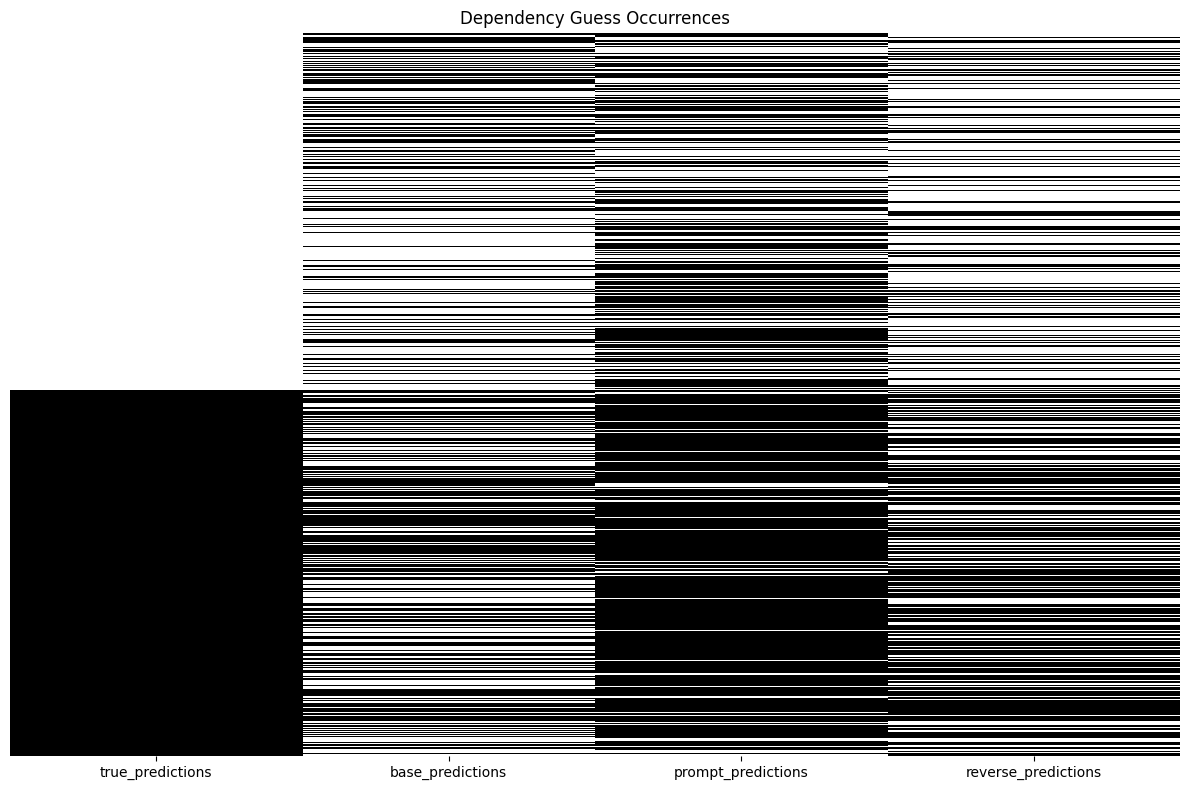

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(result_df == 1,
            cmap=['white', 'black'],
            cbar=False,
            yticklabels=False,
            xticklabels=result_df.columns)
plt.title('Dependency Guess Occurrences')
plt.tight_layout()
plt.show()


In [22]:
# Do the first 50 with one-shot non-dependent example and the compare with the first 50 with the prior one-shot.
# Then done, do write up.

In [29]:
# #test_samples = combined_data['test_must_why']
# test_data = test_df

# prompt = """
# Consider the following example as a precursor to a question:

# 1. Gather ingredients: flour, eggs
# 2. [Missing Step]
# 3. Pre-heat oven to 350 degrees F.

# In this example, pre-heating the oven to 350 degrees F has no dependency on us gathering the ingredients flour and eggs.

# For the following plan and question, return ONLY 0 if the pair in question is non-dependent and 1 if pair is dependent.
# Again, your response should only be either a 0 or 1.

# """
# #time.sleep(60)

# batch_size = 50
# ond_prompted_predictions = []

# for i in range(0, 50, batch_size):
#     batch = test_data[i:i + batch_size]

#     try:
#         # Generate predictions for the batch
#         batch_responses = [base_model.generate_content(prompt + "\n" + inp['text_input']) for _, inp in batch.iterrows()]
#         ond_prompted_predictions.extend(batch_responses)
#     except Exception as e:
#         print(f"Error processing batch {i//batch_size + 1}: {e}")
#         time.sleep(5)  # Wait before retrying

#     # Rate limit handling (add delays if necessary)
#     print("sleep for a minute")
#     time.sleep(70)

# ond_prompted_predictions_str = [prediction.text.strip() for prediction in ond_prompted_predictions]


sleep for a minute


In [30]:
# #ond_prompted_predictions_str
# unique_predictions = set(prediction.strip() for prediction in ond_prompted_predictions_str)
# unique_predictions


{'0', '1'}

In [31]:
# ond_prompted_predictions_int = [int(prediction) for prediction in ond_prompted_predictions_str]
# ond_prompted_predictions_df = pd.DataFrame(ond_prompted_predictions_int, columns=["Numbers"])
# ond_prompted_predictions_df.to_csv("./drive/MyDrive/ond_prompted_predictions_1.csv", index=False)


In [33]:
# true_labels = true_predictions['true_predictions'].to_list()

In [35]:
# #filtered_true_labels = true_labels.copy()
# filtered_true_labels = np.array(true_labels)
# filtered_true_labels = filtered_true_labels[0:50]
# ond_prompted_predictions_int = np.array(ond_prompted_predictions_int, dtype=int)

# valid_indexes = ond_prompted_predictions_int != -1
# print(len(filtered_true_labels))
# print(len(valid_indexes))
# filtered_true_labels = filtered_true_labels[valid_indexes]
# filtered_ond_prompted_predictions_int = ond_prompted_predictions_int[valid_indexes]

50
50


In [36]:
# precision, recall, f1, _ = precision_recall_fscore_support(filtered_true_labels, filtered_ond_prompted_predictions_int, average='binary')
# accuracy = accuracy_score(filtered_true_labels, filtered_ond_prompted_predictions_int)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")


Accuracy: 0.7
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
# precision, recall, f1, _ = precision_recall_fscore_support(filtered_true_labels, result_df['prompt_predictions'].to_list()[0:50], average='binary')
# accuracy = accuracy_score(filtered_true_labels, result_df['prompt_predictions'].to_list()[0:50])

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")


Accuracy: 0.56
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Hypotheses Results

### Hypothesis 1 results:

There is definately a bias. The model with the dependent example guessed dependent 1001 times. The base model with no example in the prompt guessed only 622 times. The distribution differences are also different in the figure shown above.

### Hypothesis 2 results:
The dependent example for idea #2 prompt caused the model to guess dependent 1001 times compared to the reversed plan and graph method, which caused the model to guess dependent 716 times. We can also see from the figure above that the distritbution of its guesses are much more even than the one-shot prompt, especially for the non-dependent samples.

### Hypothesis 3 results:

Upon using a prompt that exemplifies a non-dependent example rather than a dependent example like the one used in idea #2, the score improved in a sample set of the first 50 plans (all of the first 50 are non-dependent).

Out of the first 50 non-dependent plans, the original prompted model answered the questions correctly 56% of the time, whereas the new non-dependent prompted model answered it 70% of the time.

It is still to be explored if the opposite occurred to the dependent subset of the database (if a new bias was created).